#### OpenCV DNN을 이용하여 SSD 기반 Object Detection 수행
* Tensorflow에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행

#### SSD+Inception Object Detection 수행

###### 입력이미지로 사용될 이미지 다운로드

In [6]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2021-10-14 07:25:28--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.01s   

2021-10-14 07:25:28 (24.6 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



###### Tensorflow에서 Pretrained 된 Inference 모델과 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt 에서 다운로드
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.

In [ ]:
!mkdir ./pretrained

!wget -O ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz 
!wget -O ./pretrained/ssd_config_01.pbtxt  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt

!tar -xvf ./pretrained/ssd_inception*.tar.gz -C ./pretrained

--2021-10-13 13:04:13--  http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2017_11_17.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.128, 2404:6800:4008:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278126337 (265M) [application/x-tar]
Saving to: ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’

./pretrained/ssd_in 100%[===================>] 265.24M  27.3MB/s    in 9.7s    

2021-10-13 13:04:24 (27.3 MB/s) - ‘./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz’ saved [278126337/278126337]

--2021-10-13 13:04:25--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/ssd_inception_v2_coco_2017_11_17.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [ ]:
!pwd
!ls -lia ./pretrained/ssd_inception*

/content
2261 -rw-r--r-- 1 root   root 278126337 Nov 18  2017 ./pretrained/ssd_inception_v2_coco_2017_11_17.tar.gz

./pretrained/ssd_inception_v2_coco_2017_11_17:
total 201120
2263 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 .
2254 drwxr-xr-x 3 root   root      4096 Oct 13 13:04 ..
2272 -rw-r----- 1 275875 5000        77 Nov 18  2017 checkpoint
2267 -rw-r----- 1 275875 5000 101987441 Nov 18  2017 frozen_inference_graph.pb
2268 -rw-r----- 1 275875 5000 100214372 Nov 18  2017 model.ckpt.data-00000-of-00001
2264 -rw-r----- 1 275875 5000     18073 Nov 18  2017 model.ckpt.index
2266 -rw-r----- 1 275875 5000   3701354 Nov 18  2017 model.ckpt.meta
2269 drwxr-x--- 3 275875 5000      4096 Nov 18  2017 saved_model


###### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [ ]:
import cv2

cv_net=cv2.dnn.readNetFromTensorflow('/content/pretrained/ssd_inception_v2_coco_2017_11_17/frozen_inference_graph.pb',
                                     '/content/pretrained/ssd_config_01.pbtxt')

##### coco데이터 세트의 클래스id별 클래스명 지정

In [ ]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

##### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

(1, 1, 100, 7)
person:0.9696 1
person:0.9660 1
person:0.8916 1
person:0.6298 1
car:0.8609 3
car:0.7223 3
car:0.7184 3
car:0.7095 3
car:0.5949 3
car:0.5511 3


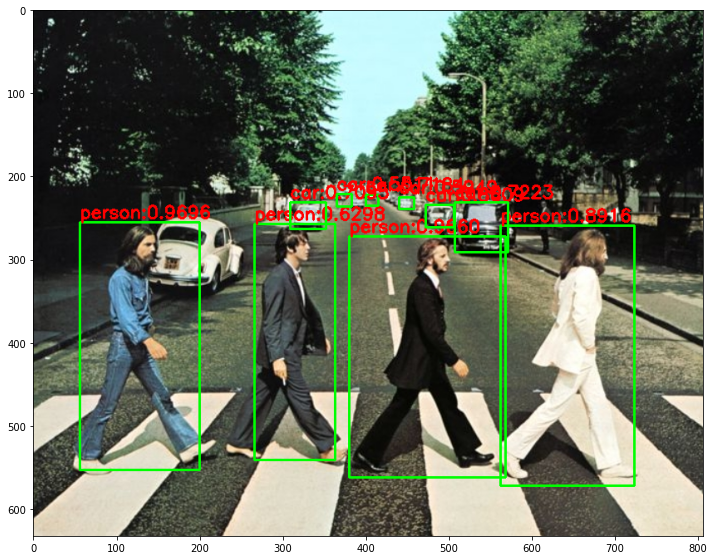

In [ ]:
import matplotlib.pyplot as plt
import cv2

img=cv2.imread('/content/data/beatles01.jpg')

#원본 이미지(633,808)를 네트웍에 입력시에는 (300,300)로 resize함
#이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측되므로 이를 다시 복원하기 위해 원본 이미지 shape정보 필요
rows=img.shape[0]
cols=img.shape[1]

drawing_img=img.copy()

#원본 이미지 배열을 사이즈 (300,300)으로, BGR을 RGB로 변환하여 배열 입력
cv_net.setInput(cv2.dnn.blobFromImage(img,size=(300,300),swapRB=True,crop=False))
cv_out=cv_net.forward()
print(cv_out.shape)

green_color=(0, 255, 0)
red_color=(0, 0, 255)

#detedted된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
  score=float(detection[2])
  class_id=int(detection[1])
  #detected된 object들의 score가 0.4이상만 추출
  if score>0.4:
    left=detection[3]*cols
    top=detection[4]*rows
    right=detection[5]*cols
    bottom=detection[6]*rows
    caption="{}:{:.4f}".format(labels_to_names[class_id],score)

    cv2.rectangle(drawing_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(drawing_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    print(caption, class_id)

img_rgb=cv2.cvtColor(drawing_img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(img_rgb)

##### 단일 이미지의 object detection을 함수로 생성

In [ ]:
import time

def get_detected_img(cv_net, img_array, score_threshold, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = img_array.copy()
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.4 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

##### Video Object Detection 수행

In [ ]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2021-10-13 13:25:10--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2021-10-13 13:25:11--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2021-10-13 13:25:11--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.

In [ ]:
def do_detected_video(cv_net,input_path,output_path,score_threshold,is_print):
  cap=cv2.VideoCapture(input_path)

  codec=cv2.VideoWriter_fourcc(*'XVID')

  vid_size=(round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  vid_fps=cap.get(cv2.CAP_PROP_FPS)

  vid_writer=cv2.VideoWriter(output_path,codec,vid_fps,vid_size)

  frame_cnt=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print('총 Frame 갯수:',frame_cnt)

  while True:
    hasFrame,img_frame=cap.read()
    if not hasFrame:
      print('더 이상 처리할 frame이 없습니다.')
      break

    returned_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
    vid_writer.write(returned_frame)
  
  vid_writer.release()
  cap.release()


In [ ]:
do_detected_video(cv_net,'/content/data/Jonh_Wick_small.mp4','./data/John_Wick_small_incept.mp4',0.2,False)

총 Frame 갯수: 58
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.32 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.33 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.36 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.35 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.37 초
Detection 수행시간: 0.34 초
Detection 수행시간: 0.3

#### SSD+Mobilenet v3 Object Detection 수행

In [2]:
import cv2
import matplotlib.pyplot as plt


In [1]:
!mkdir ./pretrained
!wget -O ./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
!wget -O ./pretrained/ssd_config_02.pbtxt https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt

!!tar -xvf ./pretrained/ssd_mobilenet*.tar.gz -C ./pretrained

--2021-10-14 07:17:56--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.140.128, 2a00:1450:400c:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.140.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49318766 (47M) [application/gzip]
Saving to: ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’

./pretrained/ssd_mo 100%[===================>]  47.03M  25.5MB/s    in 1.8s    

2021-10-14 07:17:58 (25.5 MB/s) - ‘./pretrained/ssd_mobilenet_v3_large_coco_2020_01_14.tar.gz’ saved [49318766/49318766]

--2021-10-14 07:17:58--  https://gist.githubusercontent.com/dkurt/54a8e8b51beb3bd3f770b79e56927bd7/raw/2a20064a9d33b893dd95d2567da126d0ecd03e85/ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, .

['ssd_mobilenet_v3_large_coco_2020_01_14/pipeline.config',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.index',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.data-00000-of-00001',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.tflite',
 'ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
 'ssd_mobilenet_v3_large_coco_2020_01_14/checkpoint',
 'ssd_mobilenet_v3_large_coco_2020_01_14/model.ckpt.meta',
 'ssd_mobilenet_v3_large_coco_2020_01_14/']

In [4]:
print(cv2.__version__)

4.1.2


In [1]:
!pip install opencv-python==4.5.2.54

In [15]:
cv_net_m=cv2.dnn_DetectionModel('/content/pretrained/ssd_mobilenet_v3_large_coco_2020_01_14/frozen_inference_graph.pb',
                                '/content/pretrained/ssd_config_02.pbtxt')
cv_net_m.setInputSize(320,320)
cv_net_m.setInputScale(1.0/127.5)
cv_net_m.setInputMean((127.5,127.5,127.5))
cv_net_m.setInputSwapRB(True)

<dnn_Model 0x7f492531fd10>

* dnn_Model 객체의 detect()메소드는 입력 이미지를 받아서 특정 confidence threshold이상의 모든 object inference 결과를 반환
* class id값, confidence score 값, bbox 좌표값이 array로 반환됨
* bbox좌표값의 경우 0~1사이 값이 아니라 정수형의 위치값이 반환됨.(xmin,ymin,width,height)

In [16]:
img=cv2.imread('/content/data/beatles01.jpg')
draw_img=img.copy()

classes,confidences,bboxes=cv_net_m.detect(img,confThreshold=0.5)

In [5]:
classes,confidences,bboxes

(array([[1],
        [1],
        [1],
        [1],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [1]], dtype=int32), array([[0.7795709 ],
        [0.7573837 ],
        [0.75332576],
        [0.71246046],
        [0.6756758 ],
        [0.6396257 ],
        [0.5794208 ],
        [0.5773531 ],
        [0.553491  ],
        [0.5314793 ],
        [0.50632125]], dtype=float32), array([[ 48, 258, 154, 291],
        [213, 252, 158, 298],
        [386, 266, 167, 300],
        [560, 251, 153, 322],
        [496, 226,  80,  67],
        [451, 227,  28,  21],
        [472, 226,  43,  35],
        [375, 219,  17,  17],
        [415, 220,  18,  17],
        [314, 227,  38,  23],
        [258, 259, 101, 268]], dtype=int32))

In [6]:
classes.shape,confidences.shape,bboxes.shape

((11, 1), (11, 1), (11, 4))

In [10]:
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

person:0.7796 1 [ 48 258 154 291]
person:0.7574 1 [213 252 158 298]
person:0.7533 1 [386 266 167 300]
person:0.7125 1 [560 251 153 322]
car:0.6757 3 [496 226  80  67]
car:0.6396 3 [451 227  28  21]
car:0.5794 3 [472 226  43  35]
car:0.5774 3 [375 219  17  17]
car:0.5535 3 [415 220  18  17]
car:0.5315 3 [314 227  38  23]
person:0.5063 1 [258 259 101 268]


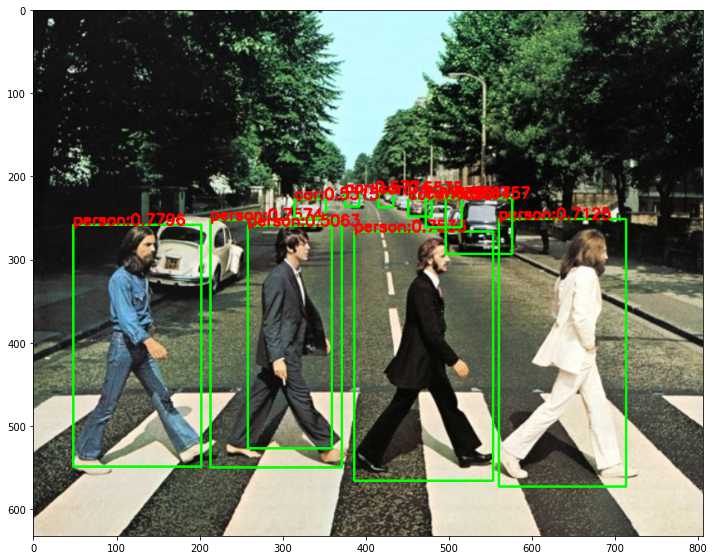

In [18]:
green_color=(0,255,0)
red_color=(0,0,255)

for class_id,confidence_score,box in zip(classes.flatten(),confidences.flatten(),bboxes):
  caption='{}:{:.4f}'.format(labels_to_names[class_id],confidence_score)
  cv2.rectangle(draw_img,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),color=green_color,thickness=2)
  cv2.putText(draw_img,caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)
  print(caption,class_id,box)

draw_img=cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(draw_img)

In [20]:
#단일 이미지의 object detection을 함수로 생성
import time 
def get_detected_img_renew(cv_net, img_array, score_threshold, is_print=True):
    
  draw_img = img_array.copy()
   
  start = time.time()

  classes, confidences, boxes = cv_net.detect(img_array, confThreshold=0.5)
  
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # detected 된 object들을 iteration 하면서 정보 추출
  for class_id, confidence_score, box in zip(classes.flatten(), confidences.flatten(), boxes):
    if confidence_score > 0.5:
      caption = "{}: {:.4f}".format(labels_to_names[class_id], confidence_score)
      cv2.rectangle(draw_img, (box[0], box[1]), (box[0]+box[2], box[1]+box[3]), color=green_color, thickness=2)
      cv2.putText(draw_img, caption, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, red_color, 2)
      print(caption)
  
  if is_print:
      print('Detection 수행시간:',round(time.time() - start, 2),"초")

  return draw_img

In [21]:
#dnn_model을 만드는 함수 생성
def get_cv_detection_model(pretrained_path,config_path):
  cv_net=cv2.dnn_DetectionModel(pretrained_path,config_path)
  cv_net.setInputSize(320,320)
  cv_net.setInputScale(1.0/127.5)
  cv_net.setInputMean((127.5,127.5,127.5))
  cv_net.setInputSwapRB(True)
  return cv_net


##### Video Inference 수행

In [22]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2021-10-14 07:45:47--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2021-10-14 07:45:48--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2021-10-14 07:45:48--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [26]:
def do_detected_video_renew(cv_net,input_path,output_path,score_threshold,is_print):
  cap=cv2.VideoCapture(input_path)

  codec=cv2.VideoWriter_fourcc(*'XVID')
  vid_size=(round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
  vid_fps=cap.get(cv2.CAP_PROP_FPS)

  vid_writer=cv2.VideoWriter(output_path,codec,vid_fps,vid_size)

  frame_cnt=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print('총 Frame 갯수:',frame_cnt)

  green_color=(0,255,0)
  red_color=(0,0,255)
  while True:
    hasFrame,img_frame=cap.read()
    if not hasFrame:
      print('더 이상 처리할 frame이 없습니다.')
      break
    return_frame=get_detected_img_renew(cv_net, img_frame, score_threshold=score_threshold, is_print=True)
    vid_writer.write(return_frame)

  vid_writer.release()
  cap.release()

In [27]:
do_detected_video_renew(cv_net_m, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_m3.mp4', 0.2, False)

총 Frame 갯수: 58
car: 0.7007
car: 0.6426
person: 0.6268
car: 0.5965
car: 0.5591
car: 0.5143
car: 0.5111
person: 0.5018
Detection 수행시간: 0.12 초
car: 0.6978
car: 0.6462
person: 0.6340
car: 0.5995
car: 0.5576
car: 0.5123
car: 0.5123
person: 0.5040
Detection 수행시간: 0.12 초
person: 0.7225
car: 0.7070
car: 0.7001
car: 0.5805
car: 0.5615
Detection 수행시간: 0.1 초
person: 0.7266
car: 0.7232
car: 0.6871
car: 0.5425
car: 0.5372
car: 0.5029
Detection 수행시간: 0.11 초
car: 0.6832
car: 0.6009
person: 0.5702
bus: 0.5572
car: 0.5494
truck: 0.5315
Detection 수행시간: 0.11 초
person: 0.6666
car: 0.6634
car: 0.5647
car: 0.5450
bus: 0.5379
car: 0.5267
car: 0.5088
Detection 수행시간: 0.1 초
car: 0.6620
person: 0.6544
car: 0.5694
bus: 0.5468
car: 0.5366
car: 0.5303
car: 0.5074
Detection 수행시간: 0.1 초
car: 0.7102
bus: 0.6212
car: 0.5881
person: 0.5652
car: 0.5506
car: 0.5125
person: 0.5110
Detection 수행시간: 0.11 초
car: 0.6820
car: 0.6173
bus: 0.5815
person: 0.5728
car: 0.5602
Detection 수행시간: 0.1 초
car: 0.6922
car: 0.6200
bus: 0.5714
